In [14]:
import yaml
import pandas as pd
import time
import joblib
from backend.utils.data_preprocessor import DataPreprocessor
from sklearn.preprocessing import MinMaxScaler
import numpy as np

with open('../config.yaml', 'r') as config_file:
    config = yaml.safe_load(config_file)

interval: str = "1min"

training_file_path: str = f"../data/twelvedata/feature time series ({interval})/AAPL_feature_time_series.csv"
validation_file_path: str = f"../data/twelvedata/feature time series ({interval})/ABBV_feature_time_series.csv"

start_time = time.time()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

training_df = pd.read_csv(training_file_path)
validation_df = pd.read_csv(validation_file_path)

for column in training_df.columns:

    numeric_column = pd.to_numeric(training_df[column], errors='coerce')
    has_infinity = np.isinf(numeric_column).any()
    if has_infinity:
        print(column, "The column contains infinity values.")

    has_zero = (training_df[column] == 'NaN').any()

    if has_zero:
        print(column, "The column contains NaN values.")


In [15]:
lookback_period: int = config['preprocess']['lookback_period']
target: str = config['preprocess']['target']
trend_length: int = config['preprocess']['trend_length']
training_preprocessor = DataPreprocessor(time_series=training_df, lookback_period=lookback_period, target=target, trend_length=trend_length)
validation_preprocessor = DataPreprocessor(time_series=validation_df, lookback_period=lookback_period, target=target, trend_length=trend_length)

X_train = training_preprocessor.feature_data_batched
y_train = training_preprocessor.label_data

X_val = validation_preprocessor.feature_data_batched
y_val = validation_preprocessor.label_data

training_preprocessor.target_data.head(500)

,open,open_1 change,open_9 change,open_1 change(%),open_9 change(%),open_1 trend,open_9 trend,high,low,close,sma,sma slope,ema,ema slope,percent_b,rsi,adx,day,hour,target trend,label
datetime,,,,,,,,,,,,,,,,,,,,,
2024-01-04 10:54:00,181.52,0.04,0.25,0.0220,0.1379,1,1,181.69,181.52,181.68,181.5144,0.0051,181.5077,0.0048,0.9359,65.4170,25.3644,3,10,1,1
2024-01-04 10:55:00,181.68,0.16,0.41,0.0881,0.2262,1,1,181.73,181.54,181.56,181.5444,0.0033,181.5182,0.0012,0.7667,56.9627,25.6166,3,10,1,1
2024-01-04 10:56:00,181.57,-0.11,0.27,-0.0605,0.1489,0,1,181.60,181.51,181.58,181.5622,0.0020,181.5306,0.0014,0.7695,57.9384,25.5191,3,10,1,1
2024-01-04 10:57:00,181.57,0.00,0.16,0.0000,0.0882,0,1,181.68,181.55,181.67,181.5844,0.0025,181.5584,0.0031,0.8559,62.1021,25.9359,3,10,1,0
2024-01-04 10:58:00,181.68,0.11,0.22,0.0606,0.1212,1,1,181.69,181.45,181.46,181.5656,-0.0021,181.5388,-0.0022,0.5613,49.7317,25.2714,3,10,0,0
2024-01-04 10:59:00,181.47,-0.21,-0.16,-0.1156,-0.0881,0,0,181.53,181.44,181.49,181.5533,-0.0014,181.5290,-0.0011,0.5848,51.2264,24.5550,3,10,0,1
2024-01-04 11:00:00,181.49,0.02,-0.11,0.0110,-0.0606,1,0,181.71,181.49,181.69,181.5711,0.0020,181.5612,0.0036,0.8429,59.8067,25.0265,3,11,1,1
2024-01-04 11:01:00,181.69,0.20,0.15,0.1102,0.0826,1,1,181.77,181.68,181.74,181.5989,0.0031,181.5970,0.0040,0.8797,61.6243,25.7749,3,11,1,1
2024-01-04 11:02:00,181.74,0.05,0.26,0.0275,0.1433,1,1,181.76,181.67,181.68,181.6167,0.0020,181.6136,0.0018,0.7745,58.2218,26.3613,3,11,1,1


,open,open_1 change,open_9 change,open_1 change(%),open_9 change(%),open_1 trend,open_9 trend,high,low,close,sma,sma slope,ema,ema slope,percent_b,rsi,adx,day,hour,target trend,label
datetime,,,,,,,,,,,,,,,,,,,,,
2024-01-04 10:54:00,181.52,0.04,0.25,0.0220,0.1379,1,1,181.69,181.52,181.68,181.5144,0.0051,181.5077,0.0048,0.9359,65.4170,25.3644,3,10,1,1
2024-01-04 10:55:00,181.68,0.16,0.41,0.0881,0.2262,1,1,181.73,181.54,181.56,181.5444,0.0033,181.5182,0.0012,0.7667,56.9627,25.6166,3,10,1,1
2024-01-04 10:56:00,181.57,-0.11,0.27,-0.0605,0.1489,0,1,181.60,181.51,181.58,181.5622,0.0020,181.5306,0.0014,0.7695,57.9384,25.5191,3,10,1,1
2024-01-04 10:57:00,181.57,0.00,0.16,0.0000,0.0882,0,1,181.68,181.55,181.67,181.5844,0.0025,181.5584,0.0031,0.8559,62.1021,25.9359,3,10,1,0
2024-01-04 10:58:00,181.68,0.11,0.22,0.0606,0.1212,1,1,181.69,181.45,181.46,181.5656,-0.0021,181.5388,-0.0022,0.5613,49.7317,25.2714,3,10,0,0
2024-01-04 10:59:00,181.47,-0.21,-0.16,-0.1156,-0.0881,0,0,181.53,181.44,181.49,181.5533,-0.0014,181.5290,-0.0011,0.5848,51.2264,24.5550,3,10,0,1
2024-01-04 11:00:00,181.49,0.02,-0.11,0.0110,-0.0606,1,0,181.71,181.49,181.69,181.5711,0.0020,181.5612,0.0036,0.8429,59.8067,25.0265,3,11,1,1
2024-01-04 11:01:00,181.69,0.20,0.15,0.1102,0.0826,1,1,181.77,181.68,181.74,181.5989,0.0031,181.5970,0.0040,0.8797,61.6243,25.7749,3,11,1,1
2024-01-04 11:02:00,181.74,0.05,0.26,0.0275,0.1433,1,1,181.76,181.67,181.68,181.6167,0.0020,181.6136,0.0018,0.7745,58.2218,26.3613,3,11,1,1


In [16]:
X_train = X_train[:-training_preprocessor.trend_length]
y_train = y_train[:-training_preprocessor.trend_length]

X_val = X_val[:-validation_preprocessor.trend_length]
y_val = y_val[:-validation_preprocessor.trend_length]

X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_val_reshaped = X_val.reshape(-1, X_val.shape[-1])

end_time = time.time()
loading_time = end_time - start_time

print("Loading time: ", loading_time)
print("Training Dataset shape:", training_df.shape)
print("Validation Dataset shape:", validation_df.shape)
print("Training sets shape:", X_train.shape, y_train.shape)
print("Validation sets shape:", X_val.shape, y_val.shape)


Loading time:  1.499485969543457
Training Dataset shape: (4970, 20)
Validation Dataset shape: (4970, 20)
Training sets shape: (4965, 3, 20) (4965,)
Validation sets shape: (4965, 3, 20) (4965,)
Loading time:  1.508300542831421
Training Dataset shape: (4970, 20)
Validation Dataset shape: (4970, 20)
Training sets shape: (4965, 3, 20) (4965,)
Validation sets shape: (4965, 3, 20) (4965,)


In [17]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler_filename: str = "scaler.save"
X_train_scaled_reshaped = scaler.fit_transform(X_train_reshaped)
X_val_scaled_reshaped = scaler.transform(X_val_reshaped)

joblib.dump(scaler, scaler_filename)

X_train_scaled = X_train_scaled_reshaped.reshape(X_train.shape)
X_val_scaled = X_val_scaled_reshaped.reshape(X_val.shape)

In [18]:
from backend.models.stock_trend_lstm_model import StockTrendLSTMModel

input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])
epochs: int = config["model"]["epochs"]
batch_size: int = config["model"]["batch_size"]
my_model = StockTrendLSTMModel(input_shape, X_train_scaled, y_train, X_val_scaled, y_val, epochs, batch_size)
history = my_model.train()



Total number of weights in the model: 1761
Epoch 1/100


156/156 [==============================] - 9s 18ms/step - loss: 0.6855 - accuracy: 0.5450 - val_loss: 0.6823 - val_accuracy: 0.5108
Epoch 2/100
156/156 [==============================] - 2s 10ms/step - loss: 0.6198 - accuracy: 0.6145 - val_loss: 0.6617 - val_accuracy: 0.5108
Epoch 3/100
156/156 [==============================] - 1s 9ms/step - loss: 0.5478 - accuracy: 0.7456 - val_loss: 0.6246 - val_accuracy: 0.6354
Epoch 4/100
156/156 [==============================] - 2s 10ms/step - loss: 0.5280 - accuracy: 0.7496 - val_loss: 0.6050 - val_accuracy: 0.7041
Epoch 5/100
156/156 [==============================] - 1s 10ms/step - loss: 0.5184 - accuracy: 0.7529 - val_loss: 0.5988 - val_accuracy: 0.7190
Epoch 6/100
156/156 [==============================] - 2s 10ms/step - loss: 0.5090 - accuracy: 0.7599 - val_loss: 0.5942 - val_accuracy: 0.7221
Epoch 7/100
156/156 [==============================] - 1s 9ms/step - loss: 0.5007 - accura

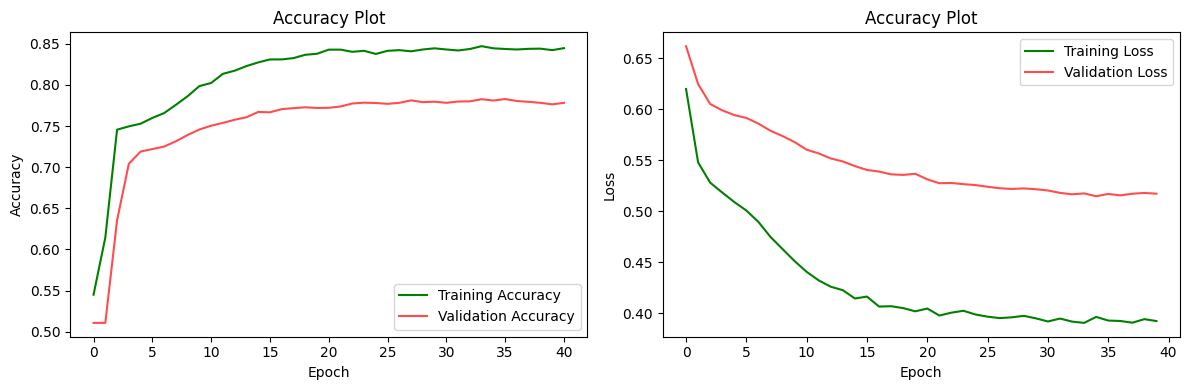

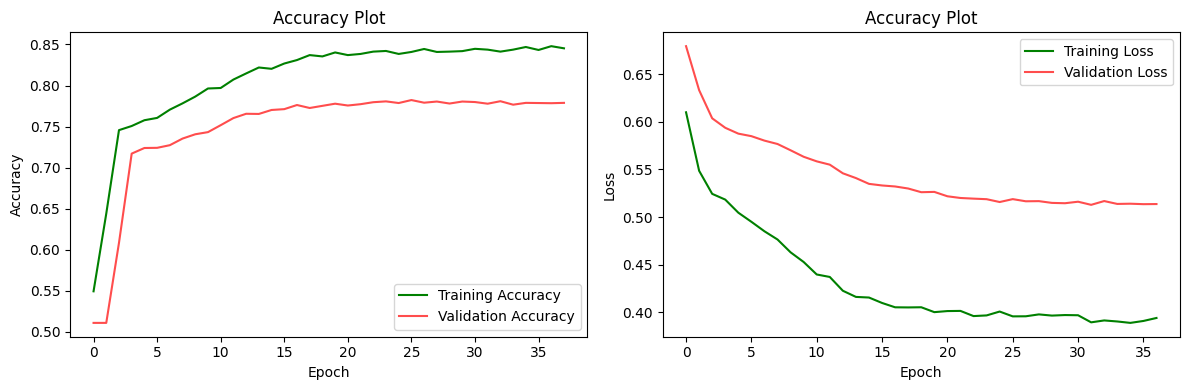

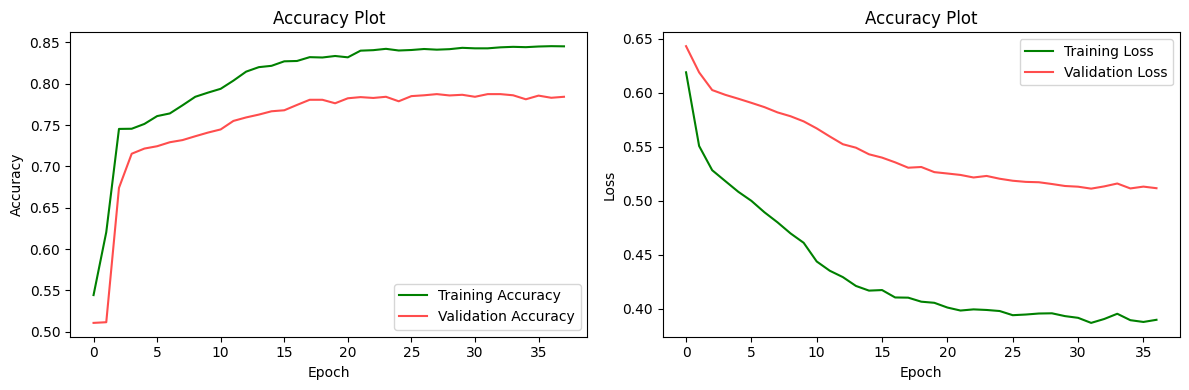

In [19]:
from backend.utils.visualizing_service import plot_model_accuracy
plot_model_accuracy(history)